In [88]:
import pandas as pd


dataframe = pd.read_csv("Exmo_BTCEUR_1h.csv", header=1)

dataframe.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume EUR
0,1.600326e+09,2020-09-17 07-AM,BTCEUR,9246.59,9251.27,9242.75,9251.27,0.00670,61.95
1,1.600322e+09,2020-09-17 06-AM,BTCEUR,9302.08,9318.55,9242.95,9246.59,0.07678,711.82
2,1.600319e+09,2020-09-17 05-AM,BTCEUR,9281.57,9322.23,9274.79,9302.08,0.09128,848.16
3,1.600315e+09,2020-09-17 04-AM,BTCEUR,9273.26,9289.01,9259.86,9281.57,0.07866,729.78
4,1.600312e+09,2020-09-17 03-AM,BTCEUR,9307.35,9309.64,9273.26,9273.26,0.09925,922.51


In [89]:
dataframe["Open_hour_before"] = dataframe["Open"].shift(-1)
dataframe["Open_changes"] = (dataframe["Open"] / dataframe["Open_hour_before"]) - 1

dataframe = dataframe.dropna()
dataframe.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume EUR,Open_hour_before,Open_changes
0,1.600326e+09,2020-09-17 07-AM,BTCEUR,9246.59,9251.27,9242.75,9251.27,0.00670,61.95,9302.08,-0.005965
1,1.600322e+09,2020-09-17 06-AM,BTCEUR,9302.08,9318.55,9242.95,9246.59,0.07678,711.82,9281.57,0.002210
2,1.600319e+09,2020-09-17 05-AM,BTCEUR,9281.57,9322.23,9274.79,9302.08,0.09128,848.16,9273.26,0.000896
3,1.600315e+09,2020-09-17 04-AM,BTCEUR,9273.26,9289.01,9259.86,9281.57,0.07866,729.78,9307.35,-0.003663
4,1.600312e+09,2020-09-17 03-AM,BTCEUR,9307.35,9309.64,9273.26,9273.26,0.09925,922.51,9338.39,-0.003324


In [90]:
changes = dataframe["Open_changes"]

In [91]:
import numpy as np

X = []
Y = []

for i in range(0, len(changes) - 20):
    Y.append(changes[i])
    X.append(np.array(changes[i+1:i+21][::-1]))

    
X = np.array(X).reshape(-1, 20, 1)
Y = np.array(Y)

In [92]:
from keras.models import Sequential
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(1, input_shape=(20, 1)))

model.compile(optimizer="rmsprop", loss="mse")
model.fit(X, Y, batch_size=32, epochs=10)

Epoch 1/10
880/880 [==============================] - 4s 4ms/step - loss: 9.4039e-05
Epoch 2/10
880/880 [==============================] - 3s 4ms/step - loss: 9.0963e-05
Epoch 3/10
880/880 [==============================] - 4s 4ms/step - loss: 9.0546e-05
Epoch 4/10
880/880 [==============================] - 4s 4ms/step - loss: 9.0527e-05
Epoch 5/10
880/880 [==============================] - 4s 4ms/step - loss: 9.0540e-05
Epoch 6/10
880/880 [==============================] - 4s 4ms/step - loss: 9.0508e-05
Epoch 7/10
880/880 [==============================] - 4s 4ms/step - loss: 9.0475e-05
Epoch 8/10
880/880 [==============================] - 4s 4ms/step - loss: 9.0489e-05
Epoch 9/10
880/880 [==============================] - 4s 4ms/step - loss: 9.0435e-05
Epoch 10/10
880/880 [==============================] - 4s 4ms/step - loss: 9.0483e-05


In [93]:
predictions = model.predict(X)
predictions = predictions.reshape(-1)

predictions

array([-2.2753463e-04, -6.7829111e-05,  1.6398972e-04, ...,
       -1.2145648e-03,  4.5696544e-04,  3.9111081e-04], dtype=float32)

In [94]:
predictions = np.append(predictions, np.zeros(20))

dataframe["predictions"] = predictions


dataframe["Open_predicted"] = dataframe["Open_hour_before"] * (1 + dataframe["predictions"])
dataframe.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume EUR,Open_hour_before,Open_changes,predictions,Open_predicted
0,1.600326e+09,2020-09-17 07-AM,BTCEUR,9246.59,9251.27,9242.75,9251.27,0.00670,61.95,9302.08,-0.005965,-0.000228,9299.963455
1,1.600322e+09,2020-09-17 06-AM,BTCEUR,9302.08,9318.55,9242.95,9246.59,0.07678,711.82,9281.57,0.002210,-0.000068,9280.940439
2,1.600319e+09,2020-09-17 05-AM,BTCEUR,9281.57,9322.23,9274.79,9302.08,0.09128,848.16,9273.26,0.000896,0.000164,9274.780719
3,1.600315e+09,2020-09-17 04-AM,BTCEUR,9273.26,9289.01,9259.86,9281.57,0.07866,729.78,9307.35,-0.003663,0.000076,9308.055104
4,1.600312e+09,2020-09-17 03-AM,BTCEUR,9307.35,9309.64,9273.26,9273.26,0.09925,922.51,9338.39,-0.003324,-0.000116,9337.307472


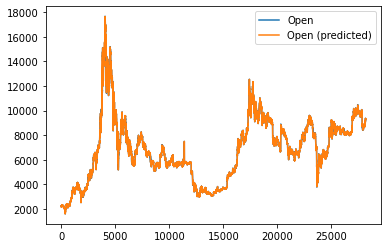

In [95]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.dates import drange

plt.plot(dataframe.index[::-1], dataframe["Open"], label="Open")
plt.plot(dataframe.index[::-1], dataframe["Open_predicted"], label="Open (predicted)")

plt.legend()

plt.show()

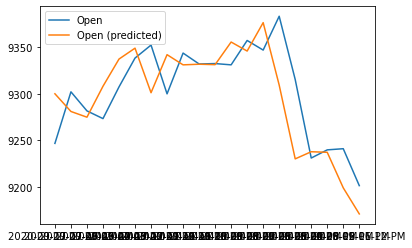

In [101]:
%matplotlib inline

plt.plot(dataframe["Date"][:20], dataframe["Open"][:20], label="Open")
plt.plot(dataframe["Date"][:20], dataframe["Open_predicted"][:20], label="Open (predicted)")

plt.legend()

plt.show()